In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_dir = "/content/drive/My Drive/Polygence/Audrey/"

In [0]:
% matplotlib inline
import matplotlib.pyplot as plt
import json
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from scipy.stats import pearsonr
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load & Process Data

## Load

In [0]:
data = pd.read_csv(root_dir + "/data/all_articles_dependencies.csv")

In [0]:
#data = data.groupby("source").filter(lambda x: len(x) > 200)

In [0]:
def get_week(row):
  year, month, day = row["publishedAt"].split("T")[0].split("-")
  return datetime.date(int(year), int(month), int(day)).isocalendar()[1]
data["week"] = data.apply(get_week, axis=1)

## Global Variables

In [0]:
names = ["Warren", "Biden", "Sanders", "Buttigieg", "Harris", "Yang", "Klobuchar"]

In [0]:
old_leanings = {"left":["cnn", "msnbc", "new-york-magazine", "the-new-york-times"], 
           "lean_left":["abc-news", "axios", "cbs-news", "nbc-news", "newsweek", "politico", "the-washington-post", "time", "vice-news"],
           "center":["al-jazeera-english", "associated-press", "reuters", "usa-today"],
           "lean_right":["fox-news", "the-american-conservative", "the-hill"],
           "right":["breitbart-news", "national-review"]}
leaning_order = ["left", "lean_left", "center", "lean_right", "right"]

In [0]:
leaning_to_source = {"left":["msnbc", "new-york-magazine"], 
           "lean_left":["axios", "cnn", "nbc-news", "the-new-york-times", "newsweek", "politico", "the-washington-post", "time", "vice-news"],
           "center":["abc-news", "cbs-news", "al-jazeera-english", "the-hill","associated-press", "reuters", "usa-today"],
           "lean_right":["the-american-conservative", "fox-news"],
           "right":["breitbart-news", "national-review"]}

In [0]:
source_to_leaning = {}
for key in leaning_to_source:
  for source in leaning_to_source[key]:
    source_to_leaning[source] = key

## Lemmatizer

In [0]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
def lemmatize(row):
  return lemmatizer.lemmatize(row["word"], pos = row["pos"])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def collecting_words(data, name):
  verbs = "\n".join(data[name + "_verbs"][~data[name + "_verbs"].isnull()].tolist())
  adjectives = "\n".join(data[name+"_adjectives"][~data[name + "_adjectives"].isnull()].tolist())
  l_verbs = []
  for word in verbs.split("\n"):
    if word == "":
      continue
    w, c = word.split(" ")
    for i in range(0,int(c)):
      l_verbs.append(w)
  l_adjectives = []
  for word in adjectives.split("\n"):
    if word == "":
      continue
    w, c = word.split(" ")
    for i in range(0,int(c)):
      l_adjectives.append(w)
  df = pd.DataFrame({"word": l_verbs + l_adjectives, "candidate": [name] * (len(l_verbs)+len(l_adjectives)), "pos": ["v"]*len(l_verbs) + ["a"]*len(l_adjectives)})
  return df

In [0]:
all_words = []
for (source, week), chunk in data.groupby(["source", "week"]):
  for name in names:
    a = collecting_words(chunk, name)
    a["source"] = source
    a["week"] = week
    all_words.append(a)
concat = pd.concat(all_words)

In [0]:
concat["leaning"] = concat["source"].map(source_to_leaning)

In [0]:
concat["lemma"] = concat.apply(lemmatize, axis=1)

In [0]:
concat.head()

,word,candidate,pos,source,week,leaning,lemma
0,said,Warren,v,abc-news,1,center,say
1,called,Warren,v,abc-news,1,center,call
2,issued,Warren,v,abc-news,1,center,issue
3,tweeted,Warren,v,abc-news,1,center,tweet
4,announced,Warren,v,abc-news,1,center,announce


## Load & Process Lexicons

In [0]:
#concat[~concat["leaning"].isnull()].to_csv(root_dir + "data/concat.csv", index=False)
"""
concat_long = concat.reset_index()
concat_long = pd.melt(concat_long, id_vars=["candidate", "source", "leaning", "pos", "week", "word", "lemma"],
                      value_vars=['valence', 'arousal', 'agency', 'power', 'dominance'],
                      var_name="Dimension", value_name="Value")
concat_long.to_csv(root_dir + "data/concat_long.csv", index=False)
concat_long
"""

'\nconcat_long = concat.reset_index()\nconcat_long = pd.melt(concat_long, id_vars=["candidate", "source", "leaning", "pos", "week", "word", "lemma"],\n                      value_vars=[\'valence\', \'arousal\', \'agency\', \'power\', \'dominance\'],\n                      var_name="Dimension", value_name="Value")\nconcat_long.to_csv(root_dir + "data/concat_long.csv", index=False)\nconcat_long\n'

In [0]:
connotation = pd.read_csv(root_dir + 'data/annotated_connotation_frames/full_frame_info.txt', sep='\t')
connotation.set_index("verb", inplace=True)
perspective_ws = connotation["Perspective(ws)"].to_dict()
effect_o = connotation["Effect(o)"].to_dict()

In [0]:
concat["perspective(ws)"] = concat["lemma"].map(perspective_ws)
concat["effect(o)"] = concat["lemma"].map(effect_o)

In [0]:
poweragency = pd.read_csv(root_dir + 'data/agency_power.csv', sep=',')
replace_agency = {
    "agency_pos": 1,
    "agency_neg": 0,
    "agency_equal": 0.5
}

replace_power = {
    "power_agent": 1,
    "power_theme": 0,
    "power_equal": 0.5
}
poweragency["agency"] = poweragency["agency"].map(replace_agency)
poweragency["power"] = poweragency["power"].map(replace_power)
poweragency["lemma"] = poweragency["verb"].apply(lambda x: lemmatizer.lemmatize(x, pos="v"))
poweragency.set_index("lemma", inplace=True)
power = poweragency["power"].to_dict()
agency = poweragency["agency"].to_dict()

In [0]:
concat["power"] = concat["lemma"].map(power)
concat["agency"] = concat["lemma"].map(agency)

In [0]:
vad = pd.read_csv(root_dir + 'data/NRC-VAD-Lexicon.txt', sep='\t')

In [0]:
vad.set_index("Word", inplace=True)
valence = vad["Valence"].to_dict()
arousal = vad["Arousal"].to_dict()
dominance = vad["Dominance"].to_dict()

In [0]:
concat["valence"] = concat["word"].map(valence)
concat["arousal"] = concat["word"].map(arousal)
concat["dominance"] = concat["word"].map(dominance)

In [0]:
concat.head()

,word,candidate,pos,source,week,leaning,lemma,perspective(ws),effect(o),power,agency,valence,arousal,dominance
0,said,Warren,v,abc-news,1,center,say,0.166667,0.133333,0.5,1.0,NaN,NaN,NaN
1,called,Warren,v,abc-news,1,center,call,0.200000,0.266667,0.0,1.0,NaN,NaN,NaN
2,issued,Warren,v,abc-news,1,center,issue,0.000000,0.333333,1.0,1.0,NaN,NaN,NaN
3,tweeted,Warren,v,abc-news,1,center,tweet,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,announced,Warren,v,abc-news,1,center,announce,0.366667,0.266667,0.0,1.0,NaN,NaN,NaN


# Processing & Plotting Functions

In [0]:
leaning_order = ["left", "lean_left", "center", "lean_right", "right"]

In [0]:
def filter_null(data, colname):
  return data[~data[colname].isnull()]

In [0]:
def filter_pos(data, pos):
  return data[data["pos"] == pos]

In [0]:
def countplot(data, x_col, y_col, pos=None, hue=None, order=None):
  if pos:
    data = filter_pos(data, pos)
  sns.countplot(data=data, x=x_col, y=y_col, hue=hue, order=order)

In [0]:
def barplot(data, x_col, y_col, ylim_low=None, ylim_high=None, pos=None, hue=None, order=None, hue_order=None,
            estimator=np.mean, ylabel=None):
  data = filter_null(data, x_col)
  data = filter_null(data, y_col)
  if pos:
    data = filter_pos(data, pos)
  fig = plt.figure(dpi=200)
  sns.barplot(data=data, x=x_col, y=y_col, hue=hue, order=order, hue_order=hue_order)
  if ylim_low and ylim_high:
    plt.ylim(ylim_low, ylim_high)
  if ylabel:
    plt.ylabel(ylabel)
  #plt.savefig("varianceplot.pdf", format="pdf")

In [0]:
def lineplot(data, x_col, y_col, pos=None, hue=None, xticks=None):
  data = filter_null(data, x_col)
  data = filter_null(data, y_col)
  if pos:
    data = filter_pos(data, pos)
  sns.lineplot(data=data, x=x_col, y=y_col, hue=hue, ci=70)
  if xticks:
    plt.xticks(range(len(xticks)), xticks)

# Compare Sources

## Counts

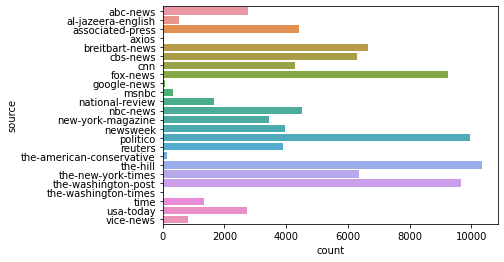

In [0]:
countplot(concat, x_col=None,  y_col="source")

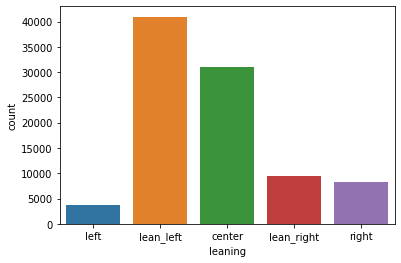

In [0]:
countplot(concat, x_col="leaning",  y_col=None, order=leaning_order)

## Verbs & Adjectives

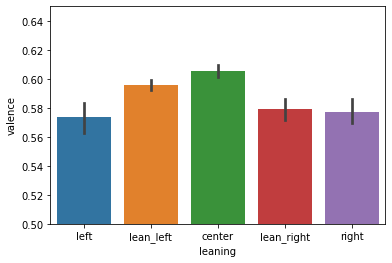

In [0]:
barplot(concat, x_col="leaning", y_col="valence", order=leaning_order, ylim_low=0.5, ylim_high=0.65)

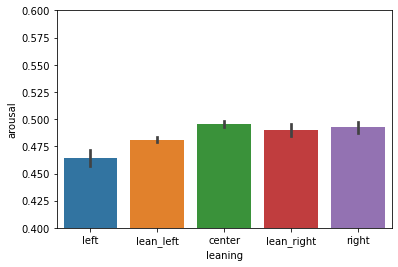

In [0]:
barplot(concat, x_col="leaning", y_col="arousal", order=leaning_order, ylim_low=0.4, ylim_high=0.6)

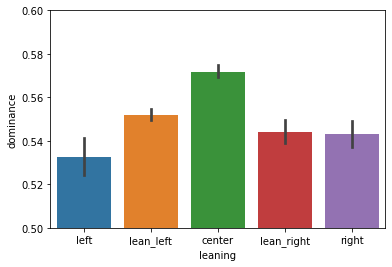

In [0]:
barplot(concat, x_col="leaning", y_col="dominance", order=leaning_order, ylim_low=0.5, ylim_high=0.6)

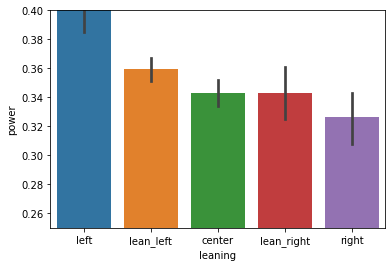

In [0]:
barplot(concat, x_col="leaning", y_col="power", order=leaning_order, ylim_low=0.25, ylim_high=0.4)

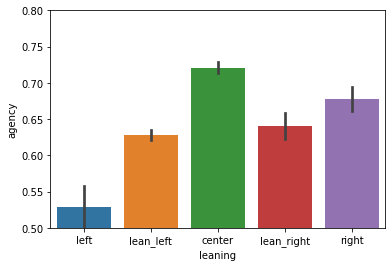

In [0]:
barplot(concat, x_col="leaning", y_col="agency", order=leaning_order, ylim_low=0.5, ylim_high=0.8)

### Specific words

## Individual Sources

# Compare Sources with Candidates

## By source

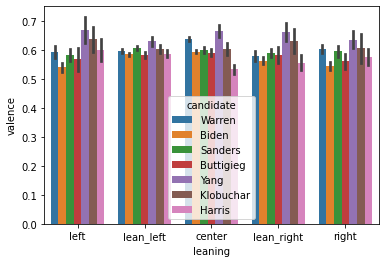

In [0]:
barplot(concat, x_col="leaning", y_col="valence", hue="candidate", order=leaning_order)

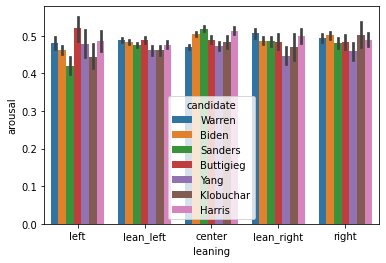

In [0]:
barplot(concat, x_col="leaning", y_col="arousal", hue="candidate", order=leaning_order)

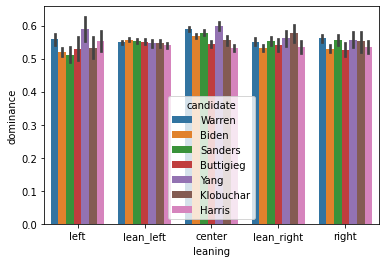

In [0]:
barplot(concat, x_col="leaning", y_col="dominance", hue="candidate", order=leaning_order)

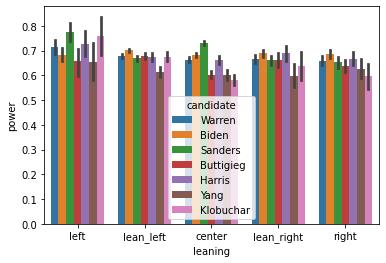

In [0]:
barplot(concat, x_col="leaning", y_col="power", hue="candidate", order=leaning_order)

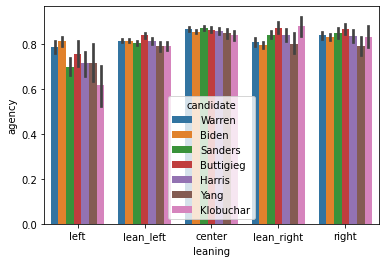

In [0]:
barplot(concat, x_col="leaning", y_col="agency", hue="candidate", order=leaning_order)

In [0]:
concat

,word,candidate,pos,source,week,leaning,lemma,perspective(ws),effect(o),power,agency,valence,arousal,dominance
0,said,Warren,v,abc-news,1,center,say,0.166667,0.133333,0.0,1.0,NaN,NaN,NaN
1,called,Warren,v,abc-news,1,center,call,0.200000,0.266667,-1.0,1.0,NaN,NaN,NaN
2,issued,Warren,v,abc-news,1,center,issue,0.000000,0.333333,1.0,1.0,NaN,NaN,NaN
3,tweeted,Warren,v,abc-news,1,center,tweet,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,announced,Warren,v,abc-news,1,center,announce,0.366667,0.266667,-1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,welcomed,Warren,v,vice-news,52,lean_left,welcome,0.666667,0.533333,0.0,1.0,0.927,0.585,0.700
0,raked,Sanders,v,vice-news,52,lean_left,rake,NaN,NaN,1.0,1.0,NaN,NaN,NaN
0,raised,Buttigieg,v,vice-news,52,lean_left,raise,0.233333,0.333333,1.0,1.0,0.656,0.326,0.643
1,slammed,Buttigieg,v,vice-news,52,lean_left,slam,NaN,NaN,1.0,1.0,NaN,NaN,NaN


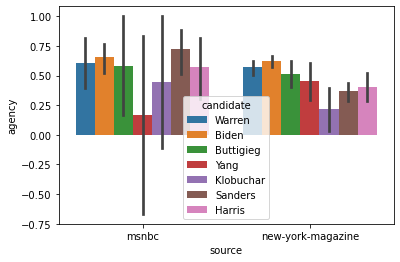

In [0]:
barplot(concat[concat["leaning"]=="left"], x_col="source", y_col="agency", hue="candidate")

## By candidate

In [0]:
#from sklearn import preprocessing
#for dim in ["valence", "arousal", "dominance", "power", "agency"]: 
#  concat[dim] = preprocessing.scale(concat[dim])

<Figure size 1200x800 with 0 Axes>

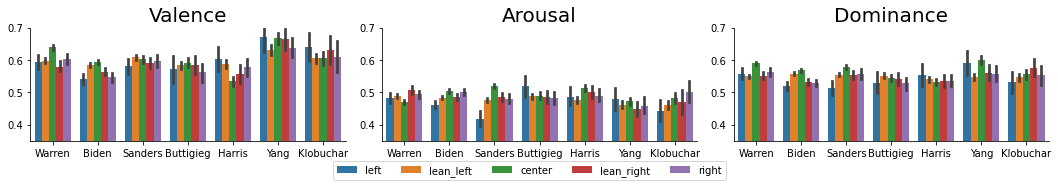

In [0]:
concat["Valence"] = concat["valence"]
concat["Arousal"] = concat["arousal"]
concat["Dominance"] = concat["dominance"]
concat_long = concat.reset_index()
concat_long = pd.melt(concat_long, id_vars=["candidate", "source", "leaning", "pos", "week", "word", "lemma"],
                      value_vars=['Valence', 'Arousal', 'Dominance'],
                      var_name="Dimension", value_name="Value")

fig = plt.figure(dpi=200)
g = sns.catplot("candidate", "Value", hue="leaning", col="Dimension", sharex=True, sharey=False,
                data=concat_long,
                kind="bar", height=2.5, aspect=2, legend=False, hue_order=leaning_order)
g.set_axis_labels("", "").set_titles("{col_name}", size=16).set(ylim=(0.35, .7))
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5)
g.savefig(root_dir + "plot_for_paper.pdf", dpi=300, format="pdf", bbox_inches="tight")


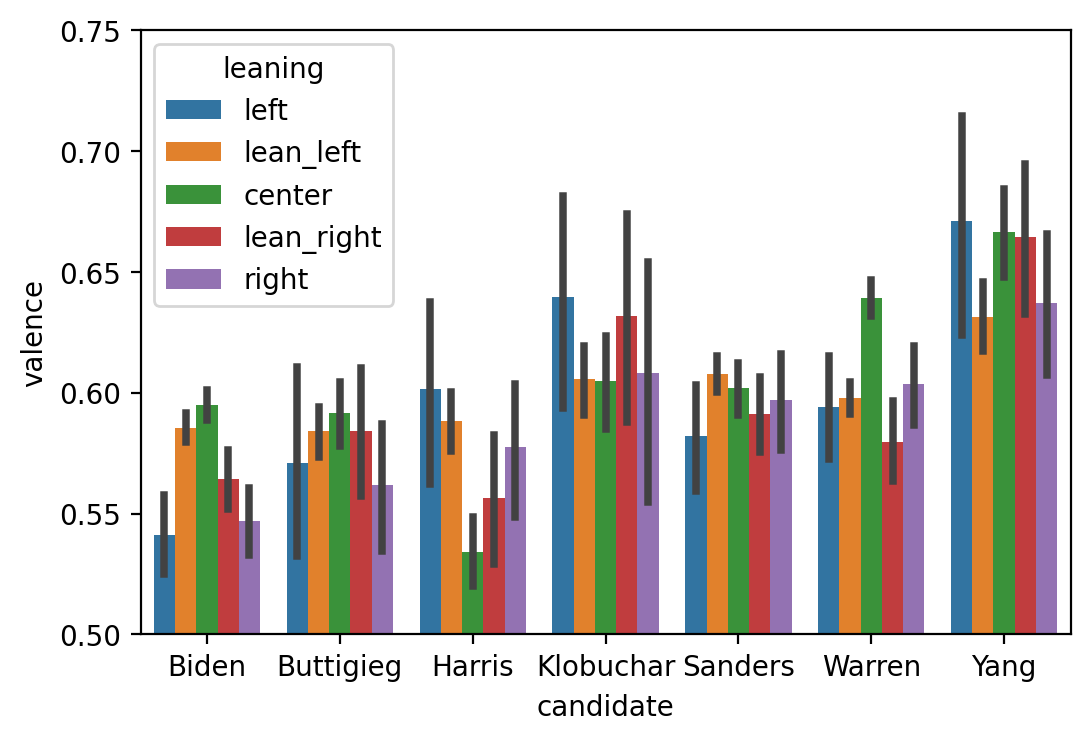

In [0]:
barplot(concat, x_col="candidate", y_col="valence", hue="leaning", hue_order=leaning_order,
        order=sorted(names), ylim_high=0.75, ylim_low=0.5)

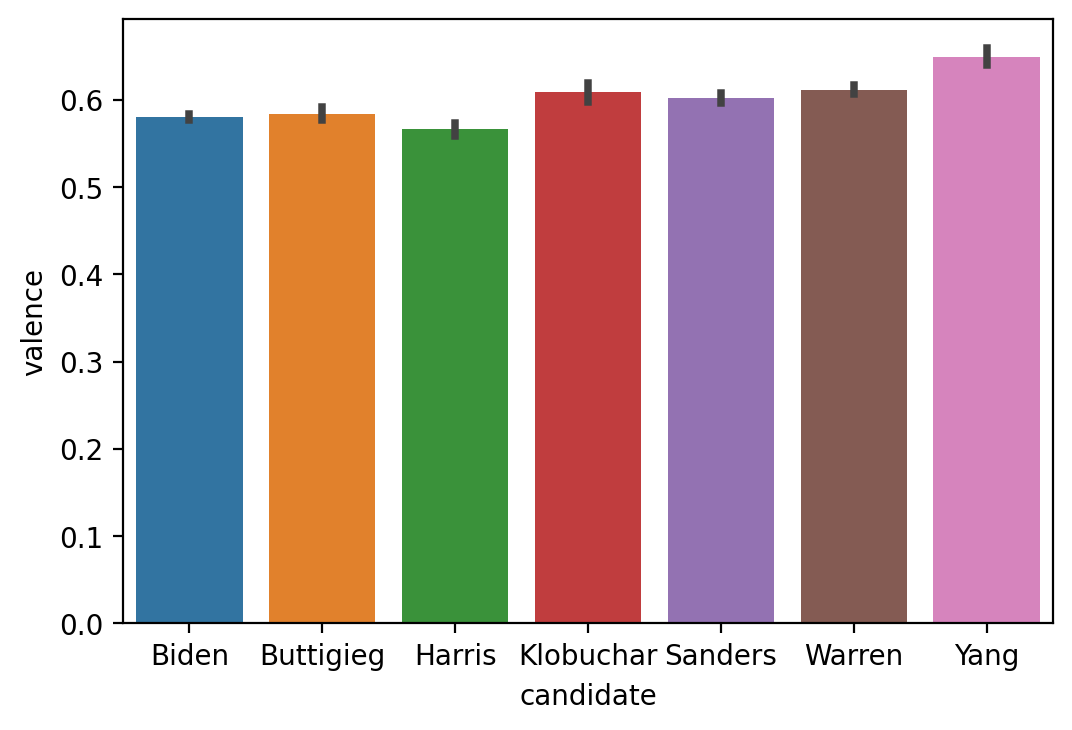

In [0]:
barplot(concat, x_col="candidate", y_col="valence",  order=sorted(names))

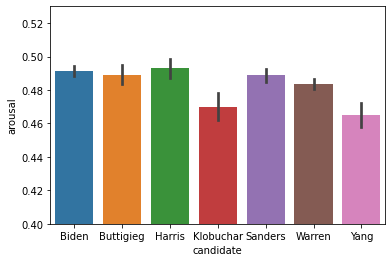

In [0]:
barplot(concat, x_col="candidate", y_col="arousal",  order=sorted(names), ylim_low=0.4, ylim_high=0.53)

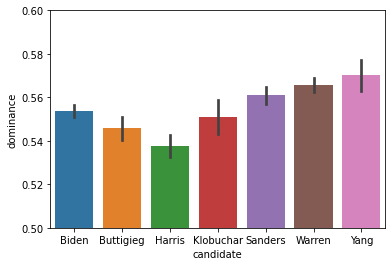

In [0]:
barplot(concat, x_col="candidate", y_col="dominance",  order=sorted(names), ylim_low=0.5, ylim_high=0.6)

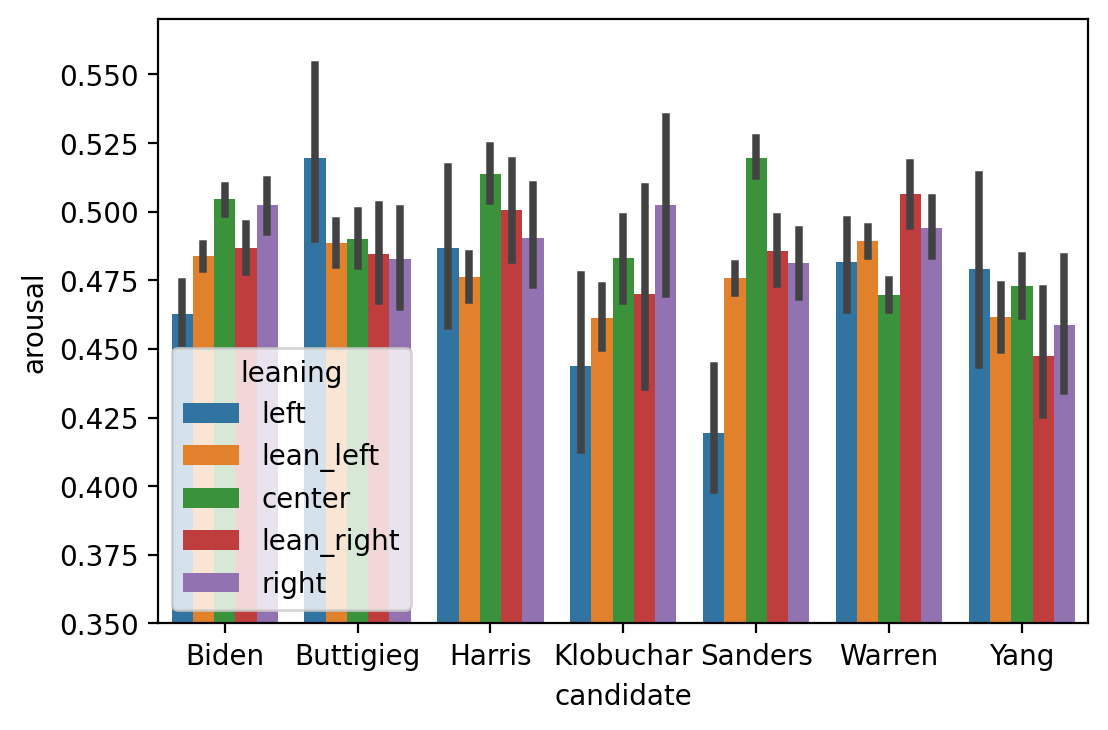

In [0]:
barplot(concat, x_col="candidate", y_col="arousal", hue="leaning", hue_order=leaning_order,
        order=sorted(names), ylim_low=0.35, ylim_high=0.57)

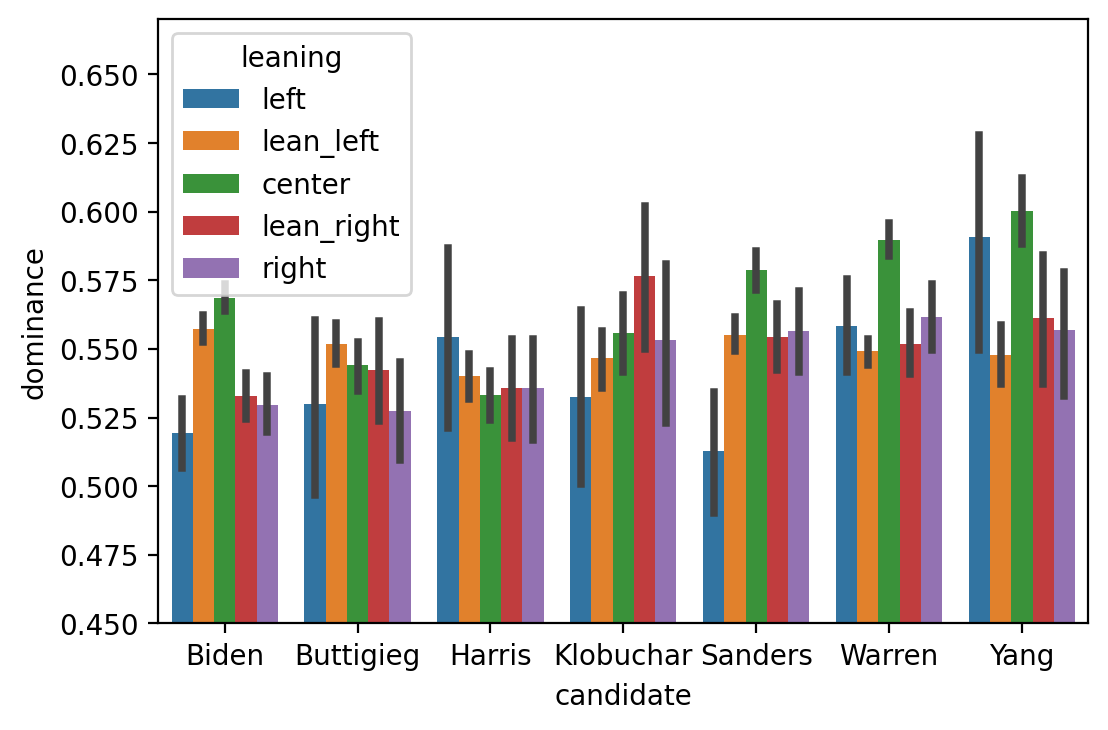

In [0]:
barplot(concat, x_col="candidate", y_col="dominance", hue="leaning", hue_order=leaning_order,
        order=sorted(names), ylim_low=0.45, ylim_high=0.67)

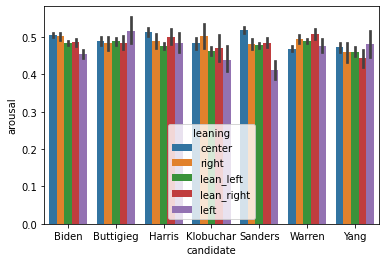

In [0]:
barplot(concat, x_col="candidate", y_col="arousal", hue="leaning", order=sorted(names))

In [0]:
candidate_group = concat.groupby("candidate")
standard_deviations = []
for i, group in candidate_group:
  means = group.groupby("source").mean()
  for dim in ["valence", "arousal", "dominance", "power", "agency"]:
    for val in means[dim]:
      standard_deviations.append({
          "Candidate": i,
          "Dimension": dim,
          "Variance Across Sources": val
      })
  print(i)


Biden
Buttigieg
Harris
Klobuchar
Sanders
Warren
Yang


In [0]:
standard_deviations = pd.DataFrame(standard_deviations)
standard_deviations

,Candidate,Dimension,Variance Across Sources
0,Biden,valence,0.039491
1,Biden,valence,-0.006694
2,Biden,valence,-0.045947
3,Biden,valence,-0.212895
4,Biden,valence,-0.245707
...,...,...,...
800,Yang,agency,-0.052222
801,Yang,agency,0.482787
802,Yang,agency,-0.108087
803,Yang,agency,-0.241102


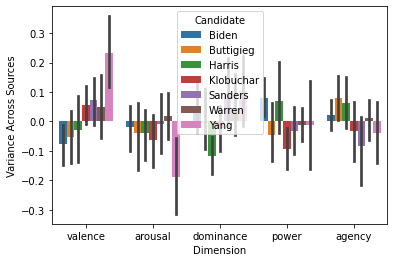

In [0]:
barplot(standard_deviations, hue="Candidate", y_col="Variance Across Sources", x_col="Dimension",
        estimator=np.std)

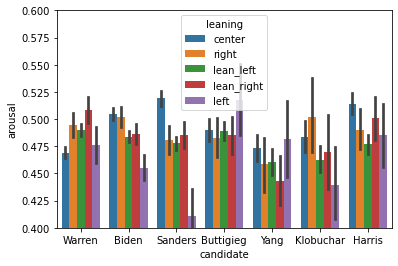

In [0]:
barplot(concat, x_col="candidate", y_col="arousal", hue="leaning", ylim_high=0.6, ylim_low=0.4)

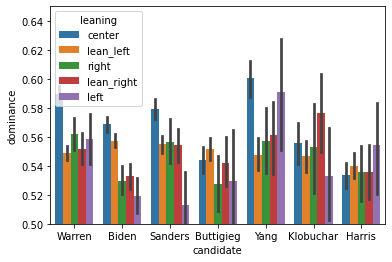

In [0]:
barplot(concat, x_col="candidate", y_col="dominance", hue="leaning", ylim_high=0.65, ylim_low=0.5)

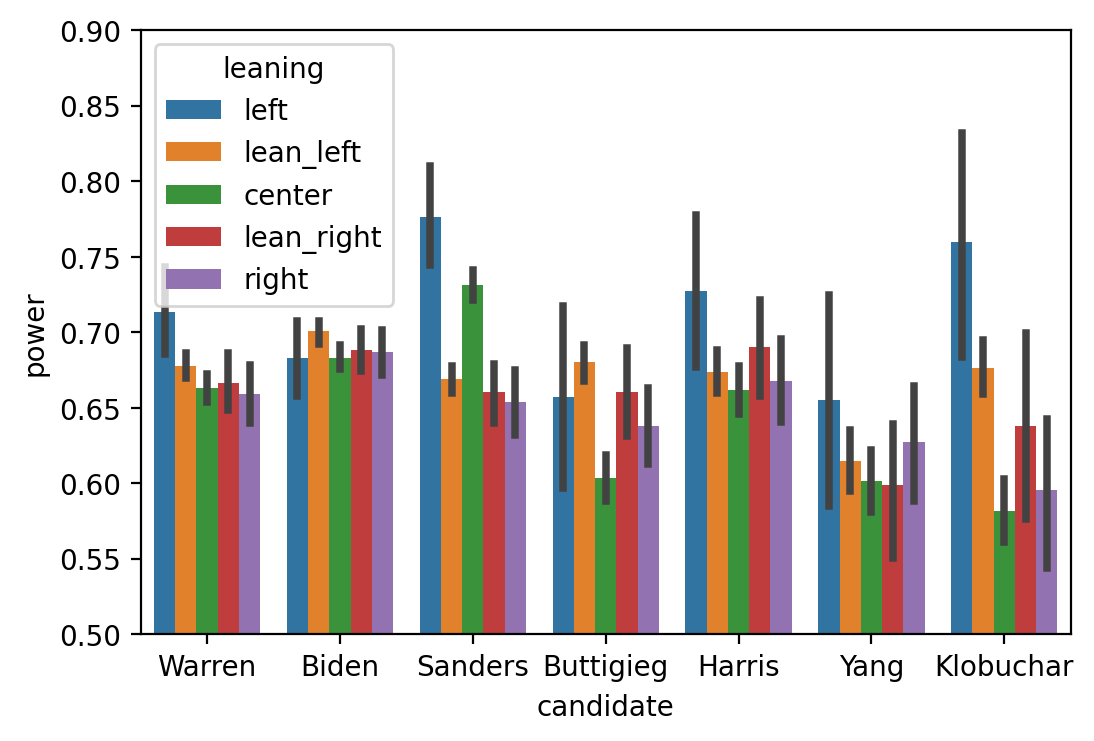

In [0]:
barplot(concat, x_col="candidate", y_col="power", hue="leaning", hue_order=leaning_order, ylim_low=0.5, ylim_high=0.9)

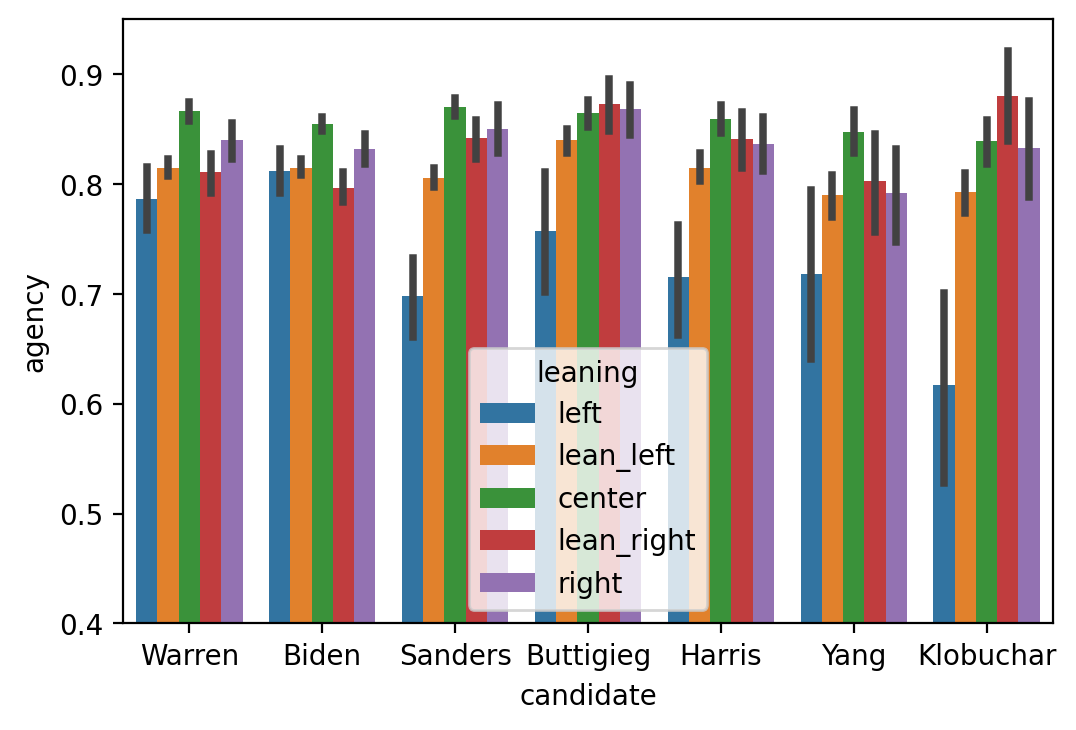

In [0]:
barplot(concat, x_col="candidate", y_col="agency", hue="leaning", hue_order=leaning_order, ylim_low=0.4, ylim_high=.95)

In [0]:
for k, v in concat[(concat["power"] == 1) & (concat["agency"] <= 0.2)]["lemma"].value_counts().to_dict().items():
  print(k,v)

have 3040
know 435
put 426
leave 224
keep 193
pay 179
acknowledge 154
expect 118
understand 104
fail 75
express 69
accept 54
let 53
watch 48
own 44
weigh 41
read 41
feature 35
invite 25
characterize 25
skip 21
afford 20
recount 19
display 14
dog 13
forget 13
doubt 12
assume 12
project 11
risk 11
imply 10
bid 10
spot 9
examine 9
envision 8
check 8
account 8
slide 8
attribute 8
excuse 7
fuel 6
resume 6
reconsider 6
record 6
precede 5
clock 5
haunt 5
neglect 5
caution 5
possess 4
gesture 4
yield 4
pocket 3
eye 3
accumulate 3
dwarf 3
usher 2
isolate 2
size 2
monitor 2
advertise 2
grasp 2
foster 2
overlap 2
overlook 2
lend 1
surrender 1
mirror 1
communicate 1
fee 1
presume 1
intrigue 1
depress 1
curse 1
inhale 1
waste 1


# Word Embedding

In [0]:
from gensim.models import phrases, word2vec, KeyedVectors
import nltk
import numpy as np
import codecs
from collections import Counter
from nltk.corpus import stopwords
import argparse
import os
import string
import re
from scipy.stats import ttest_ind

## Load Models

In [0]:
def get_models(filelist):
    model_files = [f for f in filelist if f.endswith('.wv')]
    models = []
    for fname in model_files:
      source = fname.split('/')
      source = source[len(source)-1]
      source = source.split('_')[0]
      models.append([source,KeyedVectors.load(fname, mmap='r')])
    return models

In [0]:
filelist = []
for subdir, dirs, files in os.walk(root_dir + "models/word2vec_sources"):
  for file in files:
    filelist.append(os.path.join(subdir, file))
models = get_models(filelist)
len(models)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


16

In [0]:
# Get vocab (intersection of all vocab)
vocab = set(models[0][1].vocab)
for m in models:
    vocab &= set(m[1].vocab)
len(vocab)
idx2word = {i: w for i, w in enumerate(list(vocab))}

print(models[0])

['abc-news', <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7fb1c81ca470>]


## Word Similarities

In [0]:
def get_closest(queries, models, vocab, idx2word):
    cosines = []
    for m in models:
        cosines.append([np.mean([m[1].similarity(q, word) for q in queries]) for word in vocab])
    cosines = np.mean(np.array(cosines), axis=0)
    return [(idx2word[idx], cosines[idx]) for idx in cosines.argsort()[-20:][::-1]]

In [0]:
import pandas as pd

In [0]:
def filter_words(words, vocab):
    words = set(words)
    not_in_vocab = words - vocab
    if not_in_vocab:
        print("Not in vocab:")
        print(not_in_vocab)
    return list(words - not_in_vocab)

In [0]:
def get_model_source(models, sources):
  model_sources = []
  for source in sources:
    for m in models:
      if m[0] == source:
        model_sources.append(m)
  if len(model_sources) != len(sources):
    raise ValueError("ERROR: couldn't find all sources")
  return model_sources

In [0]:
queries = ["buttigieg", "pete buttigieg", "pete"] # this should be a list of queries (it can also be just one query)

 # Remove queries not in vocab
queries = filter_words(queries, vocab)

print("Getting most similar words...")
closest = get_closest(queries, get_model_source(models, ["new-york-magazine", "cbs-news", "nbc-news", "newsweek", "politico", "the-washington-post", "the-new-york-times"]), vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))
# wealth tax for elizabeth warren, medicare for all for bernie, biden didn't have policy (impeachment)

Getting most similar words...


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


pete buttigieg 0.75
mayor pete 0.72
buttigieg 0.72
pete 0.72
klobuchar 0.71
tom steyer 0.70
amy klobuchar 0.70
south bend 0.70
andrew yang 0.68
cory booker 0.67
steyer 0.67
presidential candidate 0.66
booker 0.65
medicare for all plan 0.65
williamson 0.65
kamala harris 0.65
performances 0.65
contender 0.64
pitch 0.64
billionaire 0.63


In [0]:
print("Getting most similar words...")
closest = get_closest(queries, get_model_source(models, ["associated-press", "usa-today", "abc-news", "the-hill"]), vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))

Getting most similar words...


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


pete buttigieg 0.81
buttigieg 0.78
pete 0.78
andrew yang 0.78
mayor pete 0.76
williamson 0.76
tom steyer 0.76
amy klobuchar 0.75
kamala harris 0.75
south bend 0.75
cory booker 0.74
klobuchar 0.74
billionaire 0.72
contender 0.71
bernie 0.71
electability 0.71
yang 0.71
friend 0.70
herself 0.70
endorsement 0.70


In [0]:
print("Getting most similar words...")
closest = get_closest(queries, get_model_source(models, ["breitbart-news", "national-review", "fox-news"]), vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))

Getting most similar words...


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


mayor pete 0.76
buttigieg 0.76
pete buttigieg 0.75
klobuchar 0.74
winner 0.74
gaining 0.72
momentum 0.72
slow 0.71
herself 0.71
stuck 0.71
solid 0.71
elizabeth 0.71
contrast 0.70
tom steyer 0.70
heart attack 0.70
pitch 0.70
ryan 0.70
steyer 0.70
south bend 0.70
frequently 0.70


In [0]:
def get_cosines(name1, name2, words1, words2, queries, models):
    df_w1 = []
    df_w2 = []
    df_q = []
    df_type = []
    df_pvals = []
    for key, values in queries.items():
        for q in values:
            vals1 = [m[1].similarity(word1, q) for m in models for word1 in words1]
            vals2 = [m[1].similarity(word2, q) for m in models for word2 in words2]
            df_w1.append(np.mean(vals1))
            df_w2.append(np.mean(vals2))
            df_q.append(q)
            df_type.append(key)
            df_pvals.append(ttest_ind(vals1, vals2)[1])
    df = pd.DataFrame({name1: df_w1, name2: df_w2, 'query': df_q, 'word category': df_type, "p value": df_pvals})
    return df

In [0]:
queries = {"achievement": ["achieved", "success", "successful"], "power": ["powerful", "powers", "power"]}

#{"power": ["powerful", "power", "authority", "powers", "influence"]}
words1 = ["biden", "joe", "joe biden"]
words2 =  ["sanders", "bernie", "bernie sanders"]
# Remove queries not in vocab
words1 = filter_words(words1, vocab)
words2 = filter_words(words2, vocab)
for k, v in queries.items():
    queries[k] = filter_words(v, vocab)

Not in vocab:
{'bernie sanders'}
Not in vocab:
{'achieved'}


In [0]:
embedding_leanings = {"left":["new-york-magazine"], 
           "lean_left":["cbs-news", "nbc-news", "newsweek", "politico", "the-washington-post", "the-new-york-times"],
           "center":["associated-press", "usa-today", "abc-news", "the-hill"],
           "lean_right":["fox-news"],
           "right":["breitbart-news", "national-review"]}

for leaning in embedding_leanings:
  print(leaning)
  print(get_cosines("biden", "sanders", words1, words2, queries, get_model_source(models, embedding_leanings[leaning])))




left
      biden   sanders       query word category   p value
0  0.558794  0.560238     success   achievement  0.987348
1  0.612260  0.553469  successful   achievement  0.658003
lean_left
      biden   sanders       query word category   p value
0  0.430870  0.547621     success   achievement  0.007066
1  0.445237  0.514813  successful   achievement  0.082849
center
      biden   sanders       query word category   p value
0  0.512543  0.554663     success   achievement  0.540795
1  0.520949  0.573662  successful   achievement  0.406501
lean_right
      biden   sanders       query word category   p value
0  0.433560  0.446503     success   achievement  0.898083
1  0.410275  0.282823  successful   achievement  0.207082
right
      biden   sanders       query word category   p value
0  0.574805  0.653448     success   achievement  0.608381
1  0.629021  0.686427  successful   achievement  0.653138


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` i